In [1]:
import time
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup, element

In [15]:
def city_insight(city, page_num):
# Get the HTML from the page
    url = 'https://www.otodom.pl'
    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'html.parser')
    # search input
    key = city
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.get(url)
    time.sleep(2)
    # full screen window 
    driver.maximize_window()
    #cookie click
    cookie_click = driver.find_element(By.XPATH, '//*[@id="onetrust-accept-btn-handler"]')
    cookie_click.click()
    time.sleep(2)
    #search bar click
    search_bar = driver.find_element(By.XPATH, '//*[@id="location"]/div[2]')
    search_bar.click()
    time.sleep(2)
    #search entry
    search_entry = driver.find_element(By.XPATH, '//*[@id="location-picker-input"]')
    search_entry.send_keys(key)
    time.sleep(2)
    #search select
    search_select = driver.find_element(By.XPATH, '//*[@id="__next"]/main/section/div/div/form/div/div[1]/div[3]/div/div[1]/div/div[2]/ul/li[1]/label[1]')
    search_select.click()
    time.sleep(2)
    #search button press
    search_button = driver.find_element(By.XPATH, '//*[@id="search-form-submit"]')
    search_button.click()
    time.sleep(5)
    # getting apartments data    
    url = driver.current_url 
    res = requests.get(url)
    time.sleep(2)
    # 72 per page    
    driver.find_element(By.XPATH, '/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/div/div/div/div').click()
    time.sleep(4)
    driver.find_element(By.XPATH, '/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/div/div/div/div[2]/div/div[4]').click() 
    time.sleep(4)
    df_otodom = pd.DataFrame()

    soup_v0 = BeautifulSoup(driver.page_source, 'html.parser')

    if '...' in soup_v0.find('nav', {'class':'css-geek62 eo9qioj0'}).text:
        max_page = soup_v0.find('nav', {'class':'css-geek62 eo9qioj0'}).text.split('...')[-1]
    else:
        max_page = soup_v0.find('nav', {'class':'css-geek62 eo9qioj0'}).text[-1]
        
    max_page = int(max_page)

    if page_num < max_page:
        x = page_num
    else:
        x = max_page

    j = 3

    for i in range(0, x):
        if i != x:      
               # scroll to bottom
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)
                # getting apartments data
                url = driver.current_url
                res = requests.get(url)
                time.sleep(3)
                ##scroll to bottom
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)
                soup = BeautifulSoup(driver.page_source, 'html.parser')
                apartment = soup.find_all('li', {'class': 'css-iq9jxc e1n6ljqa1'})
                apt: element.Tag
                apartments = list()
                for apt in apartment:
                    try:
                        apartments.append({
                            'name': apt.find('h3', {'class': 'css-1mmyqk7 e1n6ljqa6'}).text,
                            'city': key,
                            'price': apt.find('span', {'class': 'css-1ntk0hg ei6hyam1'}).text,
                            'rooms': apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[2].get_text(),
                            'area': (apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[3].get_text()),
                            'price_per_m2': apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[1].get_text(),
                            'link': url + apt.find('a', {'class': 'css-1up0y1q e1n6ljqa16'}).get('href')
                        })
                    except:
                        pass
                df = pd.DataFrame(apartments)
                
                links = df['link'].tolist()
                good_links = list()
                for i in range(len(links)):
                    url = links[i]
                    prefix = 'https://www.otodom.pl'
                    suffix = url.split('/oferta/')[-1]
                    result = prefix + '/oferta/' + suffix
                    good_links.append(result)

                # replace df link column with good_links
                df['link'] = good_links
                
                additions = list()
                for x in range(len(df['link'])):
                    url = df['link'][x]
                    res = requests.get(url)
                    soup = BeautifulSoup(res.text, 'html.parser')
                    try:
                        forma_wlasnosci = soup.find('div', {'aria-label': 'Forma własności'}).find_all('div')[3].text
                    except:
                        forma_wlasnosci = None
                        
                    try:
                        stan_wykonczenia = soup.find('div', {'aria-label': 'Stan wykończenia'}).find_all('div')[3].text
                    except:
                        stan_wykonczenia = None
                        
                    try:
                        pietro = soup.find('div', {'aria-label': 'Piętro'}).find_all('div')[3].text
                    except:
                        pietro = None
                        
                    try:
                        balkon = soup.find('div', {'aria-label': 'Balkon / ogród / taras'}).find_all('div')[3].text
                    except:
                        balkon = None
                        
                    try:
                        czynsz = soup.find('div', {'aria-label': 'Czynsz'}).find_all('div')[3].text
                    except:
                        czynsz = None
                    
                    try:
                        parking = soup.find('div', {'aria-label': 'Miejsce parkingowe'}).find_all('div')[3].text
                    except:
                        parking = None
                        
                    try:
                        ogrzewanie = soup.find('div', {'aria-label': 'Ogrzewanie'}).find_all('div')[3].text
                    except:
                        ogrzewanie = None
                    
                    additions.append({
                    'forma_wlasnosci': forma_wlasnosci,
                    'stan_wykonczenia': stan_wykonczenia,
                    'pietro': pietro,
                    'balkon': balkon,
                    'czynsz': czynsz,
                    'parking': parking,
                    'ogrzewanie': ogrzewanie
                    })
                df = df.join(pd.DataFrame(additions))
                df_otodom = df_otodom.append(df)

                # scroll to top                                   
                driver.execute_script("window.scrollTo(document.body.scrollHeight,0);")
                time.sleep(2)

                if j < 6:
                    driver.find_element(By.XPATH, f'/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/nav/button[{j}]').click()           
                    time.sleep(3)
                    j = j+1
                else:
                    driver.find_element(By.XPATH, f'/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/nav/button[7]').click()
                    time.sleep(3)
                continue
        else:
            break

    df_otodom.drop_duplicates(subset=['name', 'link'], inplace=True)
    df_otodom.reset_index(drop=True, inplace=True)

    # creating insights dataframe
    insights = pd.DataFrame(index = df_otodom.index, columns= df_otodom.columns)

    # filling insights dataframe with repaired data
    for i in range(0,len(df_otodom)):
        # Name
        insights['name'] = df_otodom['name']
        # Price Columns
        insights['price'][i] = df_otodom['price'][i].replace('\xa0','').split('z')[0]
        insights['price'][i] = insights['price'][i].replace('Zapytaj o cenę','')
        insights['price'][i] = insights['price'][i].replace(',','.')

        # Rooms
        insights['rooms'][i] = df_otodom.rooms[i].split(' ')[0]
        # Area
        insights['area'][i] = df_otodom.area[i].split(' ')[0]
        # Sqm price
        insights['price_per_m2'][i] = df_otodom['price_per_m2'][i].replace('\xa0','').split('z')[0]
        # Czynsz columns
        if df_otodom['czynsz'][i] is None:
            insights['czynsz'][i] = ''
        else:
            insights['czynsz'][i] = df_otodom['czynsz'][i].split(' z')[0]
            insights['czynsz'][i] = insights['czynsz'][i].replace(' ','')
            insights['czynsz'][i] = insights['czynsz'][i].replace(',','.')
        # Link
        insights['link'][i] = df_otodom['link'][i]
        # Forma Wlasnosci
        insights['forma_wlasnosci'][i] = df_otodom['forma_wlasnosci'][i]
        # Balkon
        insights['balkon'][i] = df_otodom['balkon'][i]
        # Parking
        insights['parking'][i] = df_otodom['parking'][i]
        # Ogrzewanie
        insights['ogrzewanie'][i] = df_otodom['ogrzewanie'][i]
        # city
        insights['city'][i] = df_otodom['city'][i]

    # changing data types    
    colch = {'price', 'area', 'price_per_m2', 'czynsz', 'pietro', 'rooms'}

    for col in colch:
        insights[col] = pd.to_numeric(insights[col])

    #print(f'Insights for {city} are ready!\n\nYou can use `insights` dataframe to analyze data. HAVE FUN!')
    #return(insights)

    # plot price per m2 distribution for all apartments in Warsaw 
    plt.figure(figsize=(15, 6))
    sns.distplot(insights['price_per_m2'], bins=50, kde=False)
    plt.title(f'Price per m2 distribution for all apartments in {city}')
    plt.xlabel('Price per m2')
    plt.ylabel('Count')
    plt.show()

    plt.figure(figsize=(15, 6))
    sns.distplot(insights['price'], bins=50, kde=False)
    plt.title(f'Price distribution for all apartments in {city}')
    plt.xlabel('Price')
    plt.ylabel('Count')
    plt.show()

    plt.figure(figsize=(15, 6))
    sns.countplot(x='rooms', hue='ogrzewanie', data=insights)
    plt.title(f'Number of rooms and ogrzewanie in {city}')
    plt.xlabel('Number of rooms')
    plt.ylabel('Count')
    plt.show()

    plt.figure(figsize=(15, 6))
    sns.scatterplot(x='area', y='price', data=insights)
    plt.title(f'Price to area in {city}')
    plt.xlabel('Area')
    plt.ylabel('Price')
    plt.show()

C:\Users\mi.martowicz\AppData\Local\Temp\ipykernel_29432\2902693216.py:153: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_otodom = df_otodom.append(df)
C:\Users\mi.martowicz\AppData\Local\Temp\ipykernel_29432\2902693216.py:153: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_otodom = df_otodom.append(df)
C:\Users\mi.martowicz\AppData\Local\Temp\ipykernel_29432\2902693216.py:222: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(insights['price_per_m2'], bins=50, kde

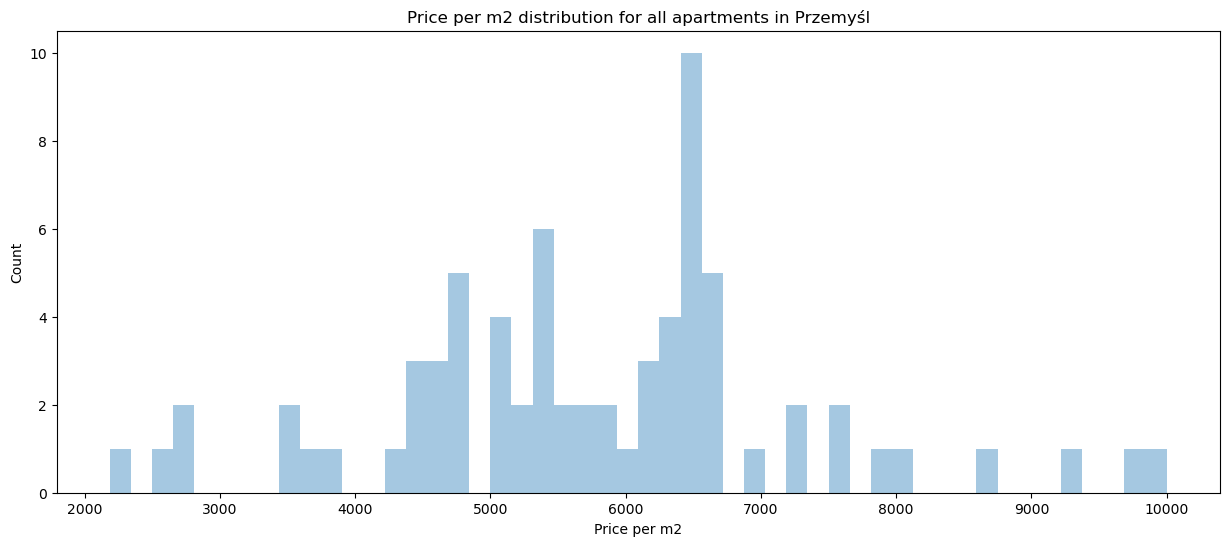

C:\Users\mi.martowicz\AppData\Local\Temp\ipykernel_29432\2902693216.py:229: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(insights['price'], bins=50, kde=False)


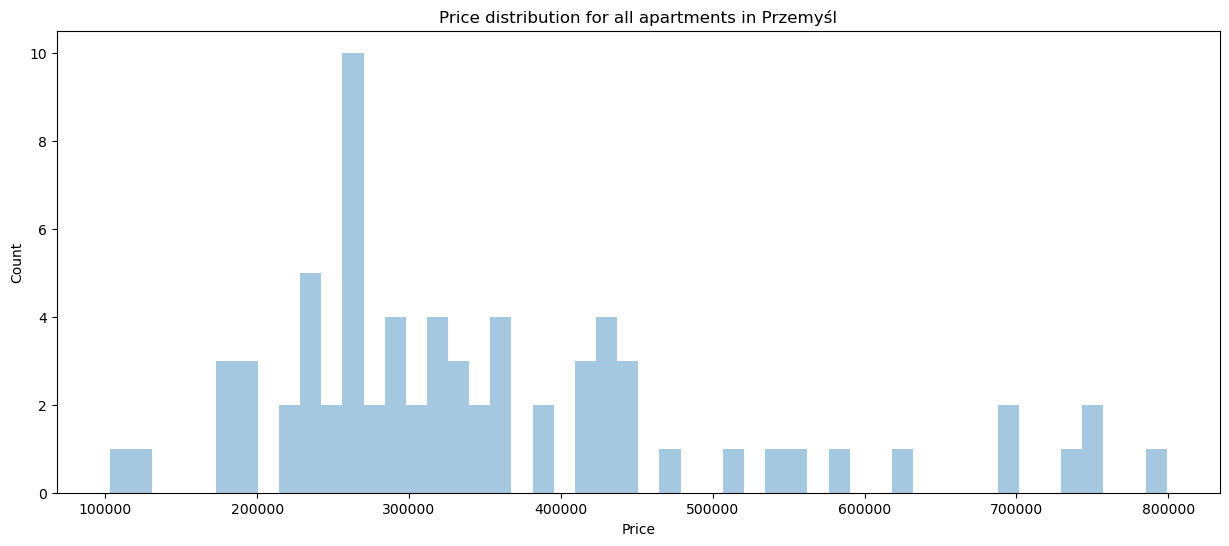

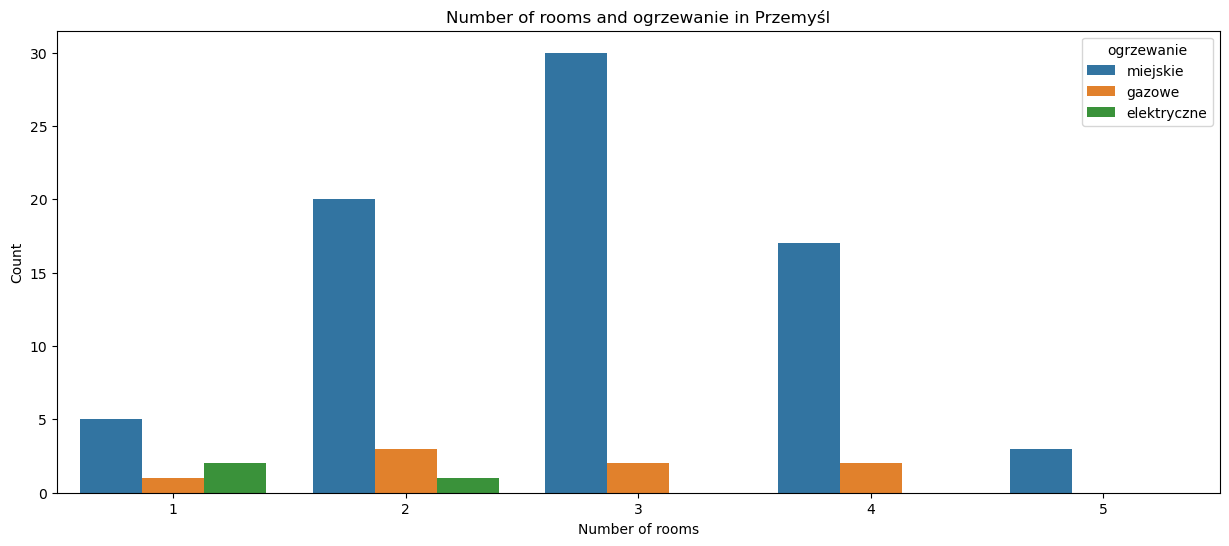

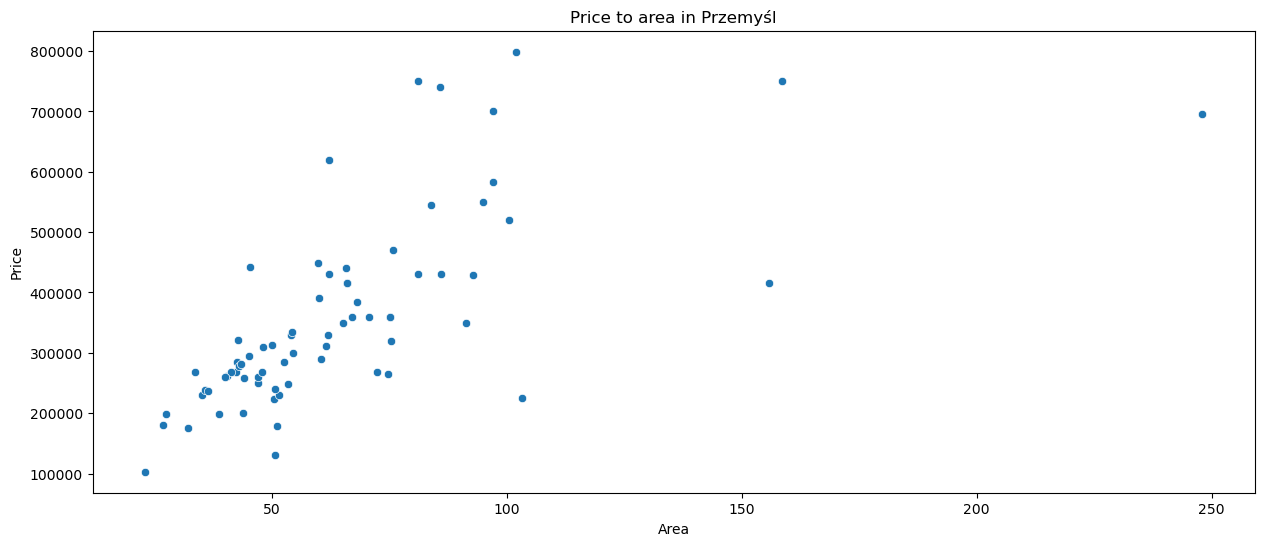

In [16]:
city_insight('Przemyśl',2)